# rGreat local vs greatpy

This notebook allows you to compare results between local rGreat and enrichment function from greatpy. 

r-base == 3.6.1

python version == 3.8 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import r as r
pandas2ri.activate()
import pandas as pd

import os 
import matplotlib.pyplot as plt
import greatpy as great 
from scipy.stats import pearsonr
import re
import time 

In [7]:
rpy2.__version__

'3.5.2'

In [3]:
importr('rGREAT')
ranges = importr('GenomicRanges')

In [12]:
def rgreat_vs_greatpy(): 
    stat_df = {
        "name" : [],
        "pearson_binom" : [], 
        "pearson_hypergeom" : []
    }
    pp = {
        "name" : [],
        "before_pp_greatpy_size" : [], 
        "before_pp_local_size" : [],
        "final_size" : [],
        "%_of_diffrent_GO_term" : [],
    }
    test_file = ["01_random.bed","06_height_snps_hg38.bed","07_height_snps_hg19.bed","10_MAX.bed"]

    for name in test_file : 
        # find the assembly 
        if re.match(".*hg19.*",name) != None : 
            assembly = "hg19"
        else : 
            assembly = "hg38"

        # local test
            # proprocessing : make a Grange frame 
        df = r["read.csv"](f"../../data/tests/test_data/input/{name}",sep='\t')
        seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
        end = rpy2.robjects.StrVector(['end', 'stop'])
        df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)#,keep_extra_columns=False,ignore_strand=False,seqinfo=None,start_field='start', end_field=end, strand_field='strand',starts_in_df_are_0based=False)

            # great calculation
        local = rpy2.robjects.r['great'](df, "msigdb:C5", f"txdb:{assembly}",verbose=False)
        local = rpy2.robjects.r['getEnrichmentTables'](local)

        time.sleep(30)

        # greatpy calculation
        greatpy = great.tl.GREAT.enrichment(
            test_file=f"../../data/tests/test_data/input/{name}",
            regdom_file=f"../../data/human/{assembly}/regulatory_domain.bed",
            chr_size_file=f"../../data/human/{assembly}/chr_size.bed",
            annotation_file=f"../../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            )

        # create each dataframe
        name_go = list(local.rx2("id")) 
        name_go = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(local.rx2("id"))]

        local = pd.DataFrame({
            "name": name_go,
            "binom_p_val" : list(local.rx2("p_value")),
            "hyper_p_val" : list(local.rx2("p_value_hyper"))
            })

        greatpy["go_term"] = greatpy["go_term"].str.lower()

        # reduce the dfs to the same GO terms 
        pp["name"].append(name)
        pp["before_pp_local_size"].append(local.shape[0])
        pp["before_pp_greatpy_size"].append(greatpy.shape[0])
        local = local.loc[local["name"].isin(list(greatpy["go_term"]))]
        greatpy = greatpy.loc[greatpy["go_term"].isin(list(local["name"]))]
        pp["final_size"].append(local.shape[0])
        pp["%_of_diffrent_GO_term"].append(round(100*(1-(pp["before_pp_greatpy_size"][-1]/pp["final_size"][-1])),2))

        # compare
        binom_greatpy = []
        hyper_greatpy = []
        binom_local = []
        hyper_local = []
        for i in range(greatpy.shape[0]) : 
            try : 
                go_term = list(greatpy["go_term"])[i]
                curr_greatpy_enrichment = greatpy.iloc[i]
                curr_rgreat_local = local.loc[local["name"]==go_term]
                binom_greatpy.append(float(curr_greatpy_enrichment["binom_p_value"]))
                hyper_greatpy.append(float(curr_greatpy_enrichment["hypergeom_p_value"]))
                binom_local.append(float(curr_rgreat_local["binom_p_val"]))
                hyper_local.append(float(curr_rgreat_local["hyper_p_val"]))
            except :
                pass
        binom = pd.DataFrame({"binom_greatpy" : binom_greatpy,"binom_local" : binom_local})
        hyper = pd.DataFrame({"hyper_greatpy" : hyper_greatpy,"hyper_local" : hyper_local})

        # plot the results 
        great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_local",title=f"binom comparison {name}")
        plt.show()
        great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_local",title=f"hyper comparison {name}")
        plt.show()

        stat_df["name"].append(name)
        stat_df["pearson_binom"].append(pearsonr(binom_greatpy,binom_local)[0])
        stat_df["pearson_hypergeom"].append(pearsonr(hyper_greatpy,hyper_local)[0])

        print(f"{name} done")

        time.sleep(90) # just to have not a burning computer ^^ 
        
    return pd.DataFrame(stat_df),pd.DataFrame(pp)

R[write to console]: * extended_tss is already cached, directly use it.



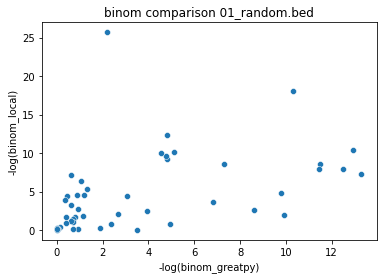

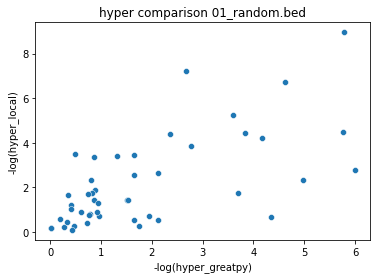

01_random.bed done


R[write to console]: * extended_tss is already cached, directly use it.



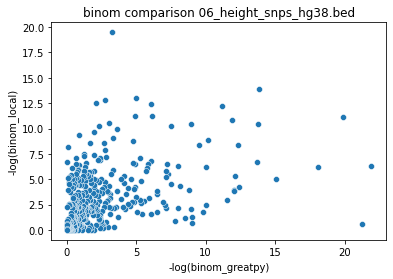

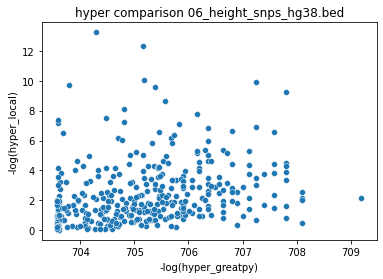

06_height_snps_hg38.bed done


R[write to console]: * check whether TxDb package 'TxDb.Hsapiens.UCSC.hg19.knownGene' is installed.

R[write to console]: * gene ID type in the extended TSS is 'Entrez Gene ID'.

R[write to console]: * restrict chromosomes to 'chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10,
    chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22, chrX,
    chrY, chrM'.

R[write to console]: * 18563/23033 protein-coding genes left.

R[write to console]: * update seqinfo to the selected chromosomes.

R[write to console]: * TSS extension mode is 'basalPlusExt'.

R[write to console]: * construct the basal domains by extending 5000bp to upstream and 1000bp to downsteram of TSS.

R[write to console]: * calculate distances to neighbour regions.

R[write to console]: * extend to both sides until reaching the neighbour genes or to the maximal extension (1000000bp).



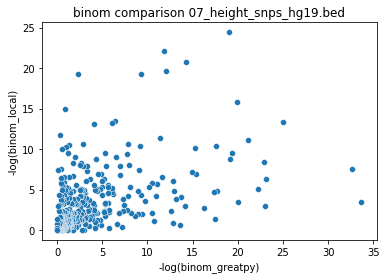

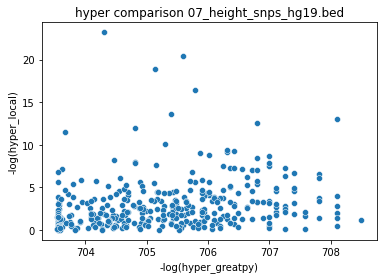

07_height_snps_hg19.bed done


R[write to console]: * extended_tss is already cached, directly use it.



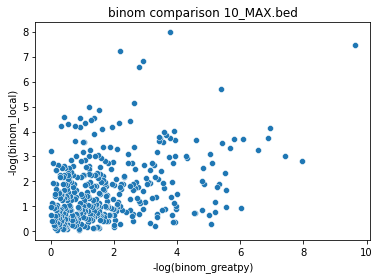

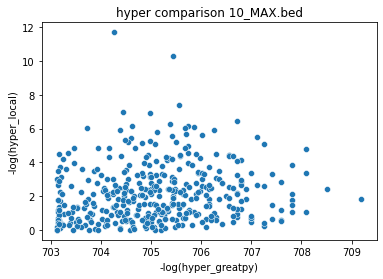

10_MAX.bed done


In [13]:
stat,preprocess = rgreat_vs_greatpy()

In [17]:
stat

,name,pearson_binom,pearson_hypergeom
0,random,5.58517e-01,6.18218e-01
1,height_snps_hg38,4.55135e-01,4.18646e-01
2,height_snps_hg19,5.40452e-01,3.27163e-01
3,MAX,2.65739e-01,2.29373e-01


As we can see the correlation between greatpy and local analysis of rGreat is not good.

In [15]:
preprocess

,name,before_pp_greatpy_size,before_pp_local_size,final_size,%_of_diffrent_GO_term
0,01_random.bed,581,577,47,-1.13617e+03
1,06_height_snps_hg38.bed,2287,1835,367,-5.23160e+02
2,07_height_snps_hg19.bed,2299,1834,369,-5.23040e+02
3,10_MAX.bed,3013,1990,402,-6.49500e+02


As we can see, the shape reduction is very high so It would to say : the GO term pick by the two function is diffrent.